# Simulation of a probabilistic photonic Controlled-Z gate

In this notebook we simulate the probabilistic photonic CZ-gate proposed by Langford et al. (http://dx.doi.org/10.1103/PhysRevLett.95.210504). In this notebook the $0=V$, $1=H$ notation is used.

In [1]:
import strawberryfields as sf
from strawberryfields.ops import *

import numpy as np
from numpy import pi, sqrt

import matplotlib.pyplot as plt

# set the random seed
np.random.seed(42)

In [20]:
#========= Circuit parameters ============

n_paths = 3
n_modes = n_paths*2
cutoff_dim = 3

#======== Initial State Preparation ==========

# Vacuum State Array
VacuumState = np.zeros([cutoff_dim] * n_modes, dtype='complex')

# Two-Qubit Input State generator
# Control and target photons enter through the first two paths
def TwoQubitStateIn(theta1, phi1, theta2 = pi/2, phi2 = 0.):
    State = np.copy(VacuumState)
    
    State[1,0,1,0,0,0] = np.cos(theta1/2)*np.cos(theta2/2)
    State[1,0,0,1,0,0] = np.cos(theta1/2)*np.sin(theta2/2)*np.exp(1j*phi2)
    State[0,1,1,0,0,0] = np.sin(theta1/2)*np.exp(1j*phi1)*np.cos(theta2/2)
    State[0,1,0,1,0,0] = np.sin(theta1/2)*np.exp(1j*phi1)*np.sin(theta2/2)*np.exp(1j*phi2)

    return State

StateDict = {
    "H" : TwoQubitStateIn(0., 0.),
    "V" : TwoQubitStateIn(pi, 0.),
    "D" : TwoQubitStateIn(pi/2, 0.),
    "A" : TwoQubitStateIn(pi/2, pi),
    "L" : TwoQubitStateIn(pi/2, pi/2),
    "R" : TwoQubitStateIn(pi/2,-pi/2)
}

#============ Gates' Construction =============

def BSgen(R = 1/3.):
    r = sqrt(R)
    t = sqrt(1-R)
    return Interferometer(np.array([[t, -r],[r, t]]))

BS1 = BSgen()
BS2 = BSgen(2/3.)

SWAPZ = Interferometer(np.array([[0,-1],[1,0]]))
SWAP = Interferometer(np.array([[0,1],[1,0]]))

def HWP(angle):
    x = np.cos(2*angle)
    y = np.sin(2*angle)
    return Interferometer(np.array([[x,y],[y,-x]]))

QWPV = Interferometer(np.exp(1j*pi/4)*np.array([[1,0],[0,-1j]]))
QWPH = Interferometer(np.exp(-1j*pi/4)*np.array([[1,0],[0,1j]]))

In [21]:
#=========== Circuit construction (for pure states) ============

PureStateProg = sf.Program(n_modes)
InitialState = PureStateProg.params('InitialState')

with PureStateProg.context as q:
    # prepare initial state
    Ket(InitialState) | q

    # QWPV for state preparation: L -> D and R -> A while H and V remain unchanged (ignoring global phases)
    #QWPV | (q[0], q[1])
    
    # First PPBS
    # Every PPBS acts as a BS for the horizontal modes and as a SWAPZ for the vertical modes
    BS1 | (q[0], q[2]) 
    SWAPZ | (q[1], q[3])
    
    # Half-wave plates
    # Since all half-wave plates used are adjusted so that H -> V and V -> H, they act as SWAP gates
    SWAP | (q[0], q[1])
    SWAP | (q[2], q[3])

    # Second and third PPBS
    # For circuit optimization, the second and third PPBS will act such that it leaves the vertical modes unchanged
    # while acting as a BS between horizontal and sink modes (modes 4 and 5)
    BS2 | (q[0], q[4])
    BS2 | (q[5], q[2])
    
    # Last SWAP
    # This swap is equivalent to adding another two HWPs at the end of the first and second paths
    # and then swapping the labels from path 1 to path 2 (this is done for compatibility of the CZ gate in computational basis)
    # The final HWPs can also be understood as changing the notation 0 <-> V, 1 <-> H to 0 <-> H, 1 <-> V
    SWAP | (q[0], q[3])
    SWAP | (q[1], q[2])
    
    # measure
    MeasureFock() | q

eng = sf.Engine('fock', backend_options={"cutoff_dim": cutoff_dim})

# Testing the CZ-Gate

In [4]:
def print_simulation_results(state, dplaces = 14):
    state = np.round(state, dplaces)
    print("="*40)
    print("Output 00 state probability amplitude:", state[0,1,0,1,0,0])
    print("Output 01 state probability amplitude:", state[0,1,1,0,0,0])
    print("Output 10 state probability amplitude:", state[1,0,0,1,0,0])
    print("Output 11 state probability amplitude:", state[1,0,1,0,0,0])
    
    print("="*40)
    print("Probability of coincidence:", np.abs(state[1,0,1,0,0,0])**2 + np.abs(state[1,0,0,1,0,0])**2 + np.abs(state[0,1,1,0,0,0])**2 + np.abs(state[0,1,0,1,0,0])**2)
    print("Probability of photon path-bunching (same polarization):", np.abs(state[2,0,0,0,0,0])**2 + np.abs(state[0,2,0,0,0,0])**2
                                                 + np.abs(state[0,0,2,0,0,0])**2 + np.abs(state[0,0,0,2,0,0])**2)
    print("Probability of photon path-bunching (different polarization):", np.abs(state[1,1,0,0,0,0])**2 + np.abs(state[0,0,1,1,0,0])**2)
    print("Probability of sinking photons:", np.abs(state[0,0,0,0,2,0])**2 + np.abs(state[0,0,0,0,0,2])**2
                            + (np.abs(state[:,:,:,:,1,:])**2).sum() + (np.abs(state[:,:,:,:,:,1])**2).sum() - np.abs(state[0,0,0,0,1,1])**2)

In [5]:
print("For an input 00 state:")

result = eng.run(PureStateProg, args={'InitialState': TwoQubitStateIn(pi, 0, pi, 0)})
print_simulation_results(result.state.data)

For an input 00 state:
Output 00 state probability amplitude: (-0.33333333333333+0j)
Output 01 state probability amplitude: (-0+0j)
Output 10 state probability amplitude: (-0+0j)
Output 11 state probability amplitude: (-0-0j)
Probability of coincidence: 0.11111111111110888
Probability of photon path-bunching (same polarization): 0.0
Probability of photon path-bunching (different polarization): 0.0
Probability of sinking photons: 0.8888888888888902


In [6]:
print("For an input 01 state:")

result = eng.run(PureStateProg, args={'InitialState': TwoQubitStateIn(pi, 0, 0, 0)})
print_simulation_results(result.state.data)

For an input 01 state:
Output 00 state probability amplitude: -0j
Output 01 state probability amplitude: (-0.33333333333333+0j)
Output 10 state probability amplitude: -0j
Output 11 state probability amplitude: -0j
Probability of coincidence: 0.11111111111110888
Probability of photon path-bunching (same polarization): 0.0
Probability of photon path-bunching (different polarization): 0.22222222222222066
Probability of sinking photons: 0.6666666666666695


In [7]:
print("For an input 10 state:")

result = eng.run(PureStateProg, args={'InitialState': TwoQubitStateIn(0, 0, pi, 0)})
print_simulation_results(result.state.data)

For an input 10 state:
Output 00 state probability amplitude: -0j
Output 01 state probability amplitude: -0j
Output 10 state probability amplitude: (-0.33333333333333+0j)
Output 11 state probability amplitude: -0j
Probability of coincidence: 0.11111111111110888
Probability of photon path-bunching (same polarization): 0.0
Probability of photon path-bunching (different polarization): 0.22222222222222066
Probability of sinking photons: 0.6666666666666695


In [8]:
print("For an input 11 state:")

result = eng.run(PureStateProg, args={'InitialState': TwoQubitStateIn(0, 0, 0, 0)})
print_simulation_results(result.state.data)

For an input 11 state:
Output 00 state probability amplitude: (-0+0j)
Output 01 state probability amplitude: -0j
Output 10 state probability amplitude: -0j
Output 11 state probability amplitude: (0.33333333333333-0j)
Probability of coincidence: 0.11111111111110888
Probability of photon path-bunching (same polarization): 0.8888888888888977
Probability of photon path-bunching (different polarization): 0.0
Probability of sinking photons: 0.0


In [9]:
print("For an input 0+ state:")

result = eng.run(PureStateProg, args={'InitialState': TwoQubitStateIn(pi, 0, pi/2, 0)})
print_simulation_results(result.state.data)

For an input 0+ state:
Output 00 state probability amplitude: (-0.23570226039552+0j)
Output 01 state probability amplitude: (-0.23570226039552+0j)
Output 10 state probability amplitude: (-0+0j)
Output 11 state probability amplitude: -0j
Probability of coincidence: 0.11111111111111503
Probability of photon path-bunching (same polarization): 0.0
Probability of photon path-bunching (different polarization): 0.11111111111110888
Probability of sinking photons: 0.777777777777768


In [10]:
print("For an input 1+ state:")

result = eng.run(PureStateProg, args={'InitialState': TwoQubitStateIn(0, 0, pi/2, 0)})
print_simulation_results(result.state.data)

For an input 1+ state:
Output 00 state probability amplitude: -0j
Output 01 state probability amplitude: -0j
Output 10 state probability amplitude: (-0.23570226039552+0j)
Output 11 state probability amplitude: (0.23570226039552-0j)
Probability of coincidence: 0.11111111111111503
Probability of photon path-bunching (same polarization): 0.4444444444444413
Probability of photon path-bunching (different polarization): 0.11111111111110888
Probability of sinking photons: 0.33333333333332954


In [11]:
print("For an input ++ state:")

result = eng.run(PureStateProg, args={'InitialState': TwoQubitStateIn(pi/2, 0, pi/2, 0)})
print_simulation_results(result.state.data)

For an input ++ state:
Output 00 state probability amplitude: (-0.16666666666667+0j)
Output 01 state probability amplitude: (-0.16666666666667+0j)
Output 10 state probability amplitude: (-0.16666666666667+0j)
Output 11 state probability amplitude: (0.16666666666667-0j)
Probability of coincidence: 0.11111111111111555
Probability of photon path-bunching (same polarization): 0.22222222222221777
Probability of photon path-bunching (different polarization): 0.11111111111111503
Probability of sinking photons: 0.5555555555555567


In [12]:
result = eng.run(PureStateProg, args={'InitialState': TwoQubitStateIn(pi/2, 0, pi/2, 0)})
print_simulation_results(result.state.data)

Output 00 state probability amplitude: (-0.16666666666667+0j)
Output 01 state probability amplitude: (-0.16666666666667+0j)
Output 10 state probability amplitude: (-0.16666666666667+0j)
Output 11 state probability amplitude: (0.16666666666667-0j)
Probability of coincidence: 0.11111111111111555
Probability of photon path-bunching (same polarization): 0.22222222222221777
Probability of photon path-bunching (different polarization): 0.11111111111111503
Probability of sinking photons: 0.5555555555555567


In [13]:
result = eng.run(PureStateProg, args={'InitialState': TwoQubitStateIn(pi/2, pi, pi/2, 0)})
print_simulation_results(result.state.data)

Output 00 state probability amplitude: (0.16666666666667-0j)
Output 01 state probability amplitude: (0.16666666666667-0j)
Output 10 state probability amplitude: (-0.16666666666667+0j)
Output 11 state probability amplitude: (0.16666666666667-0j)
Probability of coincidence: 0.11111111111111555
Probability of photon path-bunching (same polarization): 0.22222222222221777
Probability of photon path-bunching (different polarization): 0.11111111111111503
Probability of sinking photons: 0.5555555555555567


# Box A simulation

In [31]:
N = 1000

In [32]:
photons = np.array(["H"]*N + ["V"]*N)
np.random.shuffle(photons)

samplesA = []

for s in photons:
    init_state = StateDict[s]
    result = eng.run(PureStateProg, args={'InitialState': init_state})
    samplesA.append(str(result.samples[0]))

labelsA, countsA = np.unique(samplesA,return_counts=True)

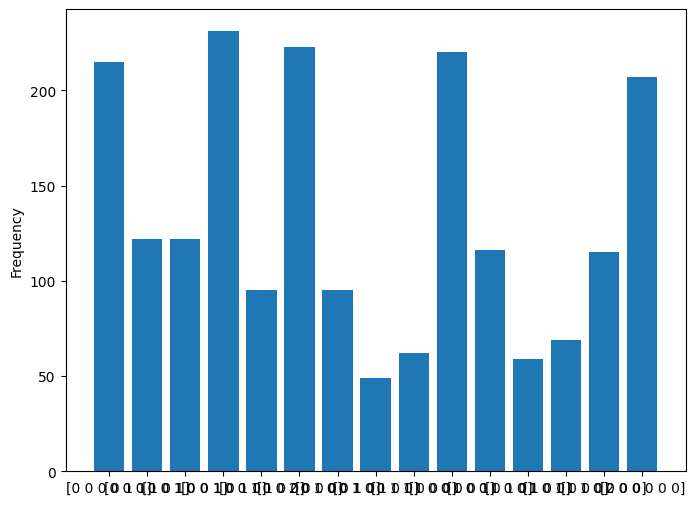

In [33]:
plt.figure(figsize=(8,6))
ticksA = range(len(countsA))
plt.bar(ticksA,countsA, align='center')
plt.xticks(ticksA, labelsA)
plt.ylabel("Frequency")
plt.show()

# Box B simulation

In [34]:
photons = np.array(["L"]*N + ["R"]*N)
np.random.shuffle(photons)

samplesB = []

for s in photons:
    init_state = StateDict[s]
    result = eng.run(PureStateProg, args={'InitialState': init_state})
    samplesB.append(str(result.samples[0]))
    
labelsB, countsB = np.unique(samplesB,return_counts=True)

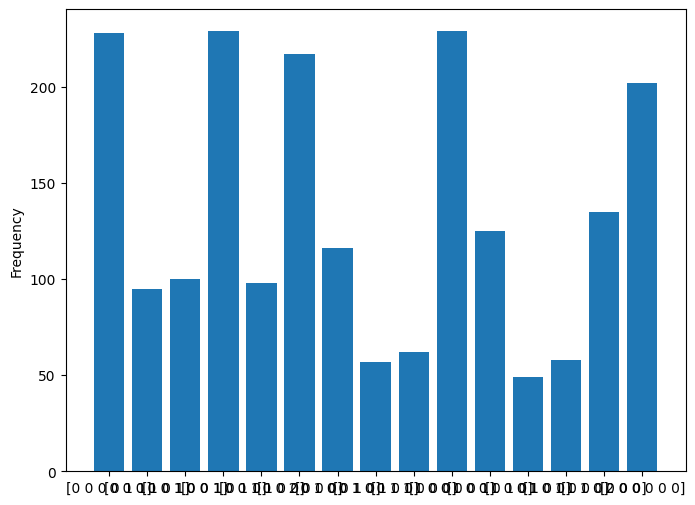

In [35]:
plt.figure(figsize=(8,6))
ticksB = range(len(countsB))
plt.bar(ticksB,countsB, align='center')
plt.xticks(ticksB, labelsB)
plt.ylabel("Frequency")
plt.show()